# Algorytmy macierzowe - zadanie nr 4 - Eliminacja Gaussa i Cholesky’ego dla macierzy rzadkich

2. Wierszowa rzadka eliminacja Choleskyego w formacie CSR

Marcin Hawryluk, Norbert Wolniak <br>grupa: piątek 12:50B <hr>

In [1]:
import numpy as np
from time import time
import pandas as pd
import matplotlib.pyplot as plt
import os
from time import time
from read_matrix import read_matrix

## Generowanie macierzy

In [2]:
matrices  = {}
for file in os.listdir('matrices'):
    matrices[file[:2]]= read_matrix('matrices/' + file)

## Eliminacja Cholesky'ego dla macierzy gęstych

In [3]:
def cholesky_LLT(matrix):
    A = matrix.copy()
    n = A.shape[0]
    
    for k in range(n):
        if abs(A[k, k]) < 1e-8:
            raise ValueError('singular matrix')
            
        vk = A[k, k+1:n]
        A[k, k] **= 0.5
        dkk = A[k, k]
        A[k, k+1:n] /= dkk
        
        
        for j in range(k+1, n):
            A[j, j:n] -= A[k, j:n]*vk[j-k-1]        
        
    return np.triu(A).T

## Format CSR

Poniższa funkcja służy do konwersji zadanej macierzy do formatu Compressed Sparse Row. 

In [4]:
def convert_to_csr(matrix):
    m, n = matrix.shape
    ICL = []
    VAL = []
    ROWPTR = []
    counter = 0
    
    for i in range(n): # rows
        ROWPTR.append(counter)
        for j in range(m): # columns
            val_ij = matrix[i, j]
            if abs(val_ij) < 1e-8:
                continue
            ICL.append(j)
            VAL.append(val_ij)
            counter += 1
            
    ROWPTR.append(counter)
    
    return ICL, VAL, ROWPTR

## Eliminacja Cholesky'ego dla macierzy rzadkich

In [5]:
def get_col_in_row(row, col):
    '''binary search for an index of value col in array row
        if col not in row returns index of the first bigger value than col
        if every value in row is smaller than col then returns None'''
    start = 0
    end = len(row)-1

    while start < end:
        middle = (start+end)//2
        if row[middle] < col:
            start = middle+1
        else:
            end = middle

    if row[start] == col:
        return start
    else:
        if start + 1 < len(row):
            return start + 1
        return None

In [11]:
def sparse_cholesky(matrix):
    '''
        returns L.T matrix in CSR format
        that (L.T.)T @ L.T == matrix
    '''
    ICL, VAL, ROWPTR = matrix
    n = len(ROWPTR) - 1
    
    for k in range(n):
        K_row_start = ROWPTR[k]
        K_row_end = ROWPTR[k+1]
        
        if ICL[K_row_start] != k or VAL[K_row_start] < 0:
            raise Exception('nonpositive value on diagonal')
    
        VAL[K_row_start] **= 0.5
        dkk = VAL[K_row_start]
        
        # last row -> nothing to eliminate
        if k == n-1: 
            break

        for j in range(K_row_start + 1, K_row_end):
            VAL[j] /= dkk
        
        new_icl = ICL[:K_row_end]
        new_val = VAL[:K_row_end]
        new_rowptr = ROWPTR[:k+2]
        
        for j in range(k+1, n):
            J_row_start = ROWPTR[j]
            J_row_end = ROWPTR[j+1]
            
            # find vk[j-k-1]
            vk_multiplier = 0
            for idx, _icl in enumerate(ICL[K_row_start:K_row_end]):
                if _icl == j:
                    vk_multiplier = VAL[K_row_start:K_row_end][idx]
            
            # if vk_multiplier == 0 then don't do anything
            if vk_multiplier == 0:
                new_icl.extend(ICL[J_row_start:J_row_end])
                new_val.extend(VAL[J_row_start:J_row_end])
                new_rowptr.append(ROWPTR[j+1])
                continue
            
            J_COLS = []
            J_VALUES = []
            for i in range(J_row_start, J_row_end):
                if j <= ICL[i] < n:
                    J_COLS.append(ICL[i])
                    J_VALUES.append(VAL[i])
            
            K_COLS = []
            K_VALUES = []
            for i in range(K_row_start, K_row_end):
                if j <= ICL[i] < n:
                    K_COLS.append(ICL[i])
                    K_VALUES.append(VAL[i])   
            
            # lists of non zero J_COLS and K_COLS, iterate and subtract correct value
            x = 0
            y = 0
            while x < len(J_COLS) and y < len(K_COLS):
                if J_COLS[x] < K_COLS[y]:
                    new_icl.append(J_COLS[x])
                    new_val.append(J_VALUES[x])
                    x += 1
                elif J_COLS[x] > K_COLS[y]:
                    new_icl.append(K_COLS[y])
                    new_val.append((-1) * K_VALUES[y] * vk_multiplier)
                    y += 1
                elif J_COLS[x] == K_COLS[y]:
                    new_icl.append(J_COLS[x])
                    new_val.append(J_VALUES[x] - (K_VALUES[y] * vk_multiplier))
                    x += 1
                    y += 1
            
            while x != len(J_COLS):
                new_icl.append(J_COLS[x])
                new_val.append(J_VALUES[x])
                x += 1
            
            while y != len(K_COLS):
                new_icl.append(K_COLS[y])
                new_val.append((-1) * K_VALUES[y] * vk_multiplier)
                y += 1
                
            # update new_rowptr
            new_rowptr.append(new_rowptr[-1] + (len(new_val) - new_rowptr[-1]))
        
        # update original ICL, VAL, ROWPTR
        ICL = new_icl
        VAL = new_val
        ROWPTR = new_rowptr

    return ICL, VAL, ROWPTR

## Test

In [12]:
def get_matrix_from_CSR(A):
    ICL, VAL, ROWPTR = A
    VAL = VAL.copy()
    
    n = len(ROWPTR) - 1
    matrix = np.zeros((n, n))

    for row in range(n):
        for j in range(ROWPTR[row], ROWPTR[row+1]):
            matrix[row, ICL[j]] = VAL[j]
            
    return matrix

In [13]:
def print_CSR_matrix(A):
    print(get_matrix_from_CSR(A))

In [14]:
test_matrix = np.array([
    [25, 0, 5, 0, 10],
    [0, 36, 0, 6, 0],
    [0, 0, 9, 0, 3],
    [0, 0, 0, 100, 0],
    [0, 0, 0, 0, 14]
], dtype=float)


lt = cholesky_LLT(test_matrix).T
sparse_lt = sparse_cholesky(convert_to_csr(test_matrix))
dense_result = get_matrix_from_CSR(sparse_lt)

print('L.T obliczone funkcją dla macierzy gęstych:')
print(lt)

print('\nL.T obliczone funkcją dla macierzy rzadkich: ')
print(dense_result)

print('\nCorrect!' if np.allclose(dense_result, lt) else '\nWrong')

L.T obliczone funkcją dla macierzy gęstych:
[[5.         0.         1.         0.         2.        ]
 [0.         6.         0.         1.         0.        ]
 [0.         0.         2.82842712 0.         0.35355339]
 [0.         0.         0.         9.94987437 0.        ]
 [0.         0.         0.         0.         3.14245127]]

L.T obliczone funkcją dla macierzy rzadkich: 
[[5.         0.         1.         0.         2.        ]
 [0.         6.         0.         1.         0.        ]
 [0.         0.         2.82842712 0.         0.35355339]
 [0.         0.         0.         9.94987437 0.        ]
 [0.         0.         0.         0.         3.14245127]]

Correct!


In [15]:
for test_matrix in matrices.values():
    lt = cholesky_LLT(test_matrix).T
    sparse_lt = sparse_cholesky(convert_to_csr(test_matrix))
    dense_result = get_matrix_from_CSR(sparse_lt)
    print('Correct!' if np.allclose(dense_result, lt) else 'Wrong')

Exception: nonpositive value on diagonal

## Porównanie czasów

In [16]:
def compare_times(matrix):
    start = time()
    cholesky_LLT(matrix)
    dense_time = time() - start
    
    start = time()
    sparse_cholesky(convert_to_csr(matrix))
    sparse_time = time() - start
    
    df = pd.DataFrame({
        'dense': [dense_time],
        'sparse': [sparse_time]
    }, index=['time [s]'])
    
    df.plot(kind='bar', cmap='viridis')
    return df

* 3a

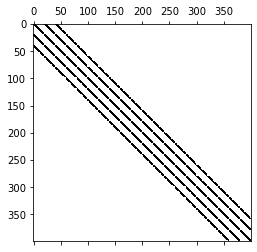

In [17]:
plt.spy(matrices['3a'])
plt.show()

In [18]:
compare_times(matrices['3a'])

Exception: nonpositive value on diagonal

* 4a

In [ ]:
plt.spy(matrices['4a'])
plt.show()

In [ ]:
compare_times(matrices['4a'])

## Wnioski

* 
* 

M. Hawryluk, N. Wolniak. 2021